# 3 - Barotropic depth-mean time series

## Imports

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [2]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/adj/adj_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/adj/adj_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]
    
#print(ds)

In [3]:
# extract plotting variables

t_stamp = ds[0].t_stamp
depth = ds[0].depth.values
start_date = ds[0].start_date
end_date = ds[0].end_date

## Depth-mean band-pass

In [8]:
# band-pass Butterworth filter

fs = 1.111e-3                                   # samples per SECOND for entire time series
band = 'Inertial'                               # Diurnal, Inertial, Semi-diurnal, Broadband
if band == 'Diurnal':
    Wn1 = 1.7e-5
    Wn2 = 0.8e-5                                # filter cut-off
elif band == 'Inertial':
    Wn1 = 2.4e-5
    Wn2 = 1.2e-5
b1, a1 = sig.butter(8, Wn1,'lowpass',analog=False,output='ba',fs=fs)        # digital butterworth filter low-pass
w1, h1 = sig.freqz(b1, a1)       
b2, a2 = sig.butter(8, Wn2,'highpass',analog=False,output='ba',fs=fs)       # digital butterworth filter high-pass
w2, h2 = sig.freqz(b2, a2)    

In [11]:
# plot filter response

# fig,ax = plt.subplots(1,1)
# ax.semilogx(w1*fs/(2*np.pi),abs(h1))          # normalised from 0 to pi (NOT 2pi)
# ax.semilogx(w2*fs/(2*np.pi),abs(h2))          # normalised from 0 to pi (NOT 2pi)
# ax.set_xlim(5e-6,5e-5)
# plt.plot()

In [12]:
# apply band-pass filter

ubp,vbp = [],[]
for i in range(n_seg):
    ubp_temp = np.zeros([len(ds[i].t_seg),len(depth)])               # empty array for band-pass filtered u values
    vbp_temp = np.zeros([len(ds[i].t_seg),len(depth)])               # empty array for band-pass filtered v values
    for j in range(len(depth)):                                      # loop for filtered data
        utemp = sig.filtfilt(b1, a1, ds[i].uorig[:,j])  # apply low pass filter
        vtemp = sig.filtfilt(b1, a1, ds[i].vorig[:,j])
        ubp_temp[:,j] = sig.filtfilt(b2, a2, utemp)  # apply high pass filter
        vbp_temp[:,j] = sig.filtfilt(b2, a2, vtemp)
    ubpds = xr.DataArray(ubp_temp,dims=('time','depth'))
    vbpds = xr.DataArray(vbp_temp,dims=('time','depth'))
    ubp.append(ubpds)
    vbp.append(vbpds)

<IPython.core.display.Javascript object>


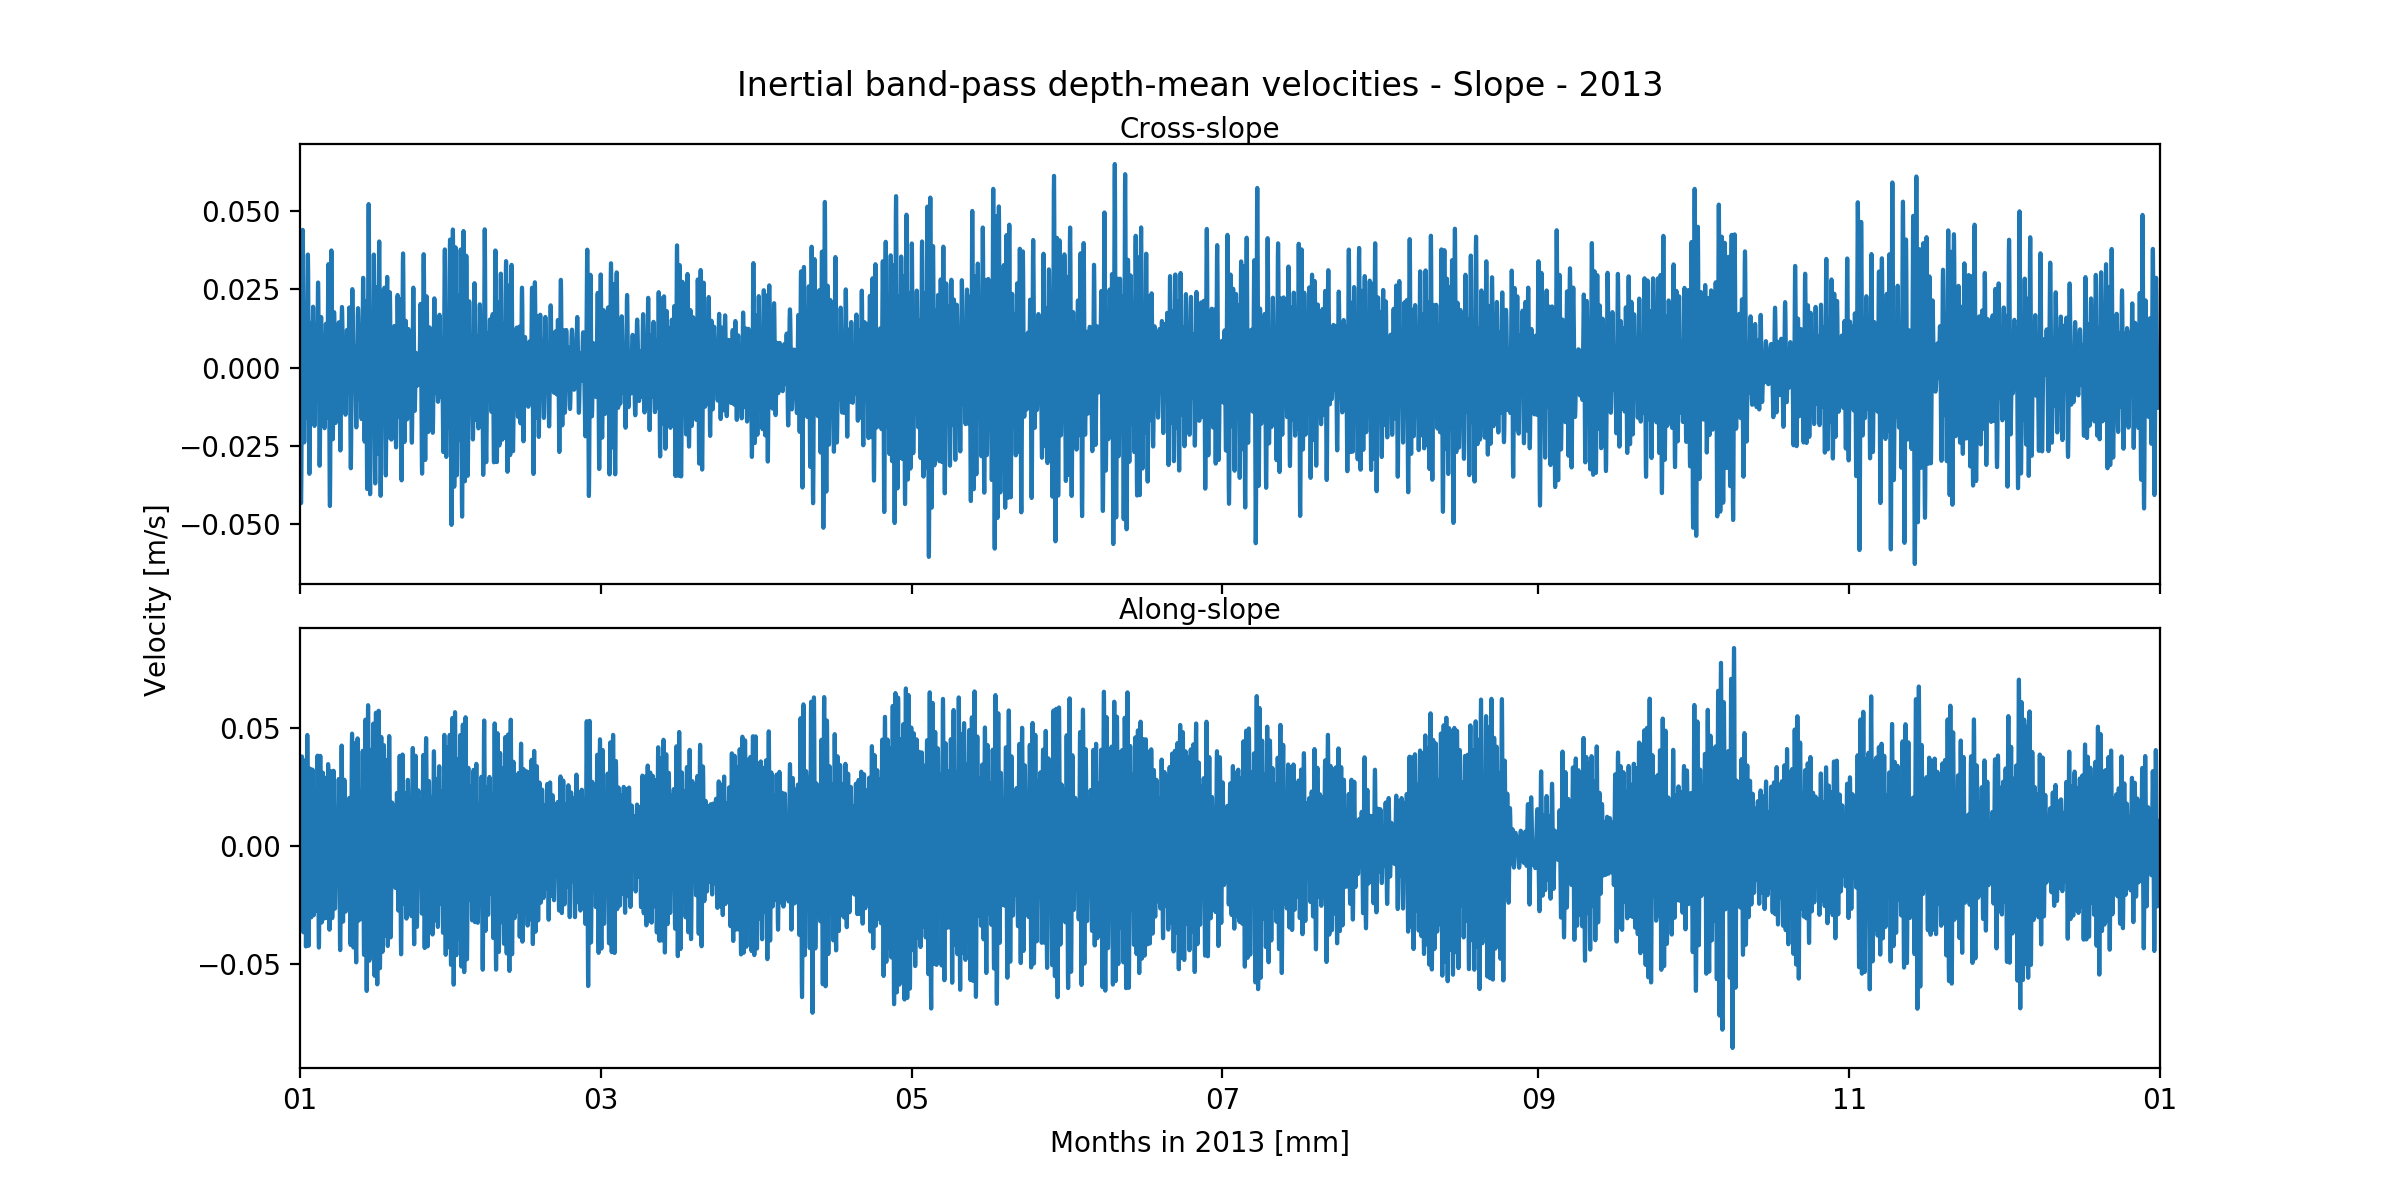

In [13]:
# plot depth-mean band-pass velocities (spring-neap)

# fig,(ax0,ax1) = plt.subplots(2,1,figsize=(12,6),sharex=True)
# fig.subplots_adjust(hspace=0.1)

# fig.text(0.5, 0.92, f'{band} band-pass depth-mean velocities - {adcp} - {t_stamp}', ha='center', fontsize=12)
# fig.text(0.06, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
# fig.text(0.5, 0.04, f'Months in {t_stamp} [mm]', ha='center')

# if adcp == 'Slope':
#     fig.text(0.5, 0.885, 'Cross-slope', ha='center', fontsize=10)
#     fig.text(0.5, 0.484, 'Along-slope', ha='center', fontsize=10)
# elif adcp == 'Axis55' or adcp == 'Axis75':
#     fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=10)
#     fig.text(0.5, 0.484, 'Along-canyon', ha='center', fontsize=10)

# for i in range(n_seg):
#     ax0.plot(ds[i].t_seg,ubp[i].mean(dim='depth'),color='C0')
#     ax1.plot(ds[i].t_seg,vbp[i].mean(dim='depth'),color='C0')

# date_form = pldates.DateFormatter("%m")
# ax1.xaxis.set_major_formatter(date_form)
# ax1.set_xlim(start_date,end_date)

# plt.show()

#plt.savefig(fname=f'./plots/vel_plots/depthmean_{adcp}_{t_stamp}.pdf',format='pdf')

In [60]:
# save to .nc files

for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            ubp=(['t_seg','depth'], ubp[i]),    # adjusted data
            vbp=(['t_seg','depth'], vbp[i]),
        ),
        coords=dict(
            depth=depth,                 # depth values
            t_seg=ds[i].t_seg,           # datetime values in segments
        ),
        attrs=dict(
            description=f'{band} band-pass data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            upidx=ds[0].upidx,           # upper depth index
            lowidx=ds[0].lowidx,         # lower depth index
            dup_stamp=ds[0].dup_stamp,   # upper depth stamp
            dlow_stamp=ds[0].dlow_stamp, # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            t=ds[0].t,                   # length of time series
            d=ds[0].d,                   # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/data/barotropic/{band}_bp_{adcp}_{t_stamp}_{i}.nc')